# Missing Data Imputation using Regression

### Why imputation?

The first question is, why do we need to impute the missing data in the first place? Can't we just delete them?

Well, that would be one method of handling missing values called __Complete Case Analysis__, something which is (very) rarely used. The obvious reason being that, if we delete the data point containing missing data (__List wise deletion__), we will end up with a small number of samples to train our learning model and thus accuracy would be of concern. And, if we summarise the variables with it's observed values (__Available Case Analysis__), we consider different samples while summarising each variable.

### Why not impute with a common value? 

Then, why not impute the missing data with the __Measure of Central Tendency__ of the variable? That does sound like a safe approach (and also pretty easy to implement).

Apparently not. 

When we replace the missing data with some common value we might under(over)estimate it. In other words, we add some bias to our estimation. For example, a person who earns just enough to meet his daily needs might not be comfortable in mentioning his salary, and thus the value for the variable `salary` would be missing for such a person. However, if we impute it with the mean value of the variable, we are overestimating that person's salary and thus introducing bias in our analysis.

### What next?

There are many missing data imputation methods to avoid these troublesome cases and __Regression Imputation__ is one such method in which we estimate the missing values by Regression using other variables as the parameters.

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


## Determining missing values 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
%matplotlib inline

Pima Indians Diabetes dataset is used for our analysis. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.  You can read more about the dataset in the `Data` section of this kernel.

After importing the required libraries, we analyse and determine for availability for any missing data.

In [3]:
df = pd.read_csv("diabetes.csv")
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


A simple `df.info()` is ran for a quick and abstract check for missing data in any of the variables. This lists the number of non-null values and the datatype of each variable.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None of the variables seem to have any missing value based on our above observation. But there's more to it than what meets the eye. `df.describe()` which gives the Five Number Summary would show that some variables have `0.0` as their minimum value which would be meaningless in their case. __Plasma glucose concentration, Diastolic blood pressure, Triceps skinfold thickness, 2-Hour serum insulin and Body mass index__ cannot be zero. 

Imagine BMI to be zero. That would be a disaster!

On the contrary, __Pregnencies__ can be zero because either that person is a female who has not had a baby yet.

In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_imp,BloodPressure_imp,SkinThickness_imp,Insulin_imp,BMI_imp
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958,121.654948,72.401042,29.005208,154.576823,32.448958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951,30.501920,12.291467,10.515152,116.895642,6.913683
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000,99.000000,64.000000,22.000000,76.000000,27.475000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000,117.000000,72.000000,29.000000,125.000000,32.350000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000,140.250000,80.000000,36.000000,190.000000,36.600000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000,199.000000,122.000000,99.000000,846.000000,67.100000


Thus, for feasibility of further analysis, we replace all these "missing" data with `nan` and calculate their number. As you can observe, there's enough evidence of significant missingness in those variables.

In [6]:
df.loc[df["Glucose"] == 0.0, "Glucose"] = np.NAN
df.loc[df["BloodPressure"] == 0.0, "BloodPressure"] = np.NAN
df.loc[df["SkinThickness"] == 0.0, "SkinThickness"] = np.NAN
df.loc[df["Insulin"] == 0.0, "Insulin"] = np.NAN
df.loc[df["BMI"] == 0.0, "BMI"] = np.NAN

df.isnull().sum()[1:6]

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

A better way of realizing this missingness is by visualizing the same using `missingno` package by drawing a nullity matrix. And as we can observe, `SkinThickness` and `Insulin` have a large amount of their data missing whose number is mentioned above. To keep our kernel short, I would consider only these variables for further visualizations.

You can learn more about `missingno` package in the link mentioned in References below.

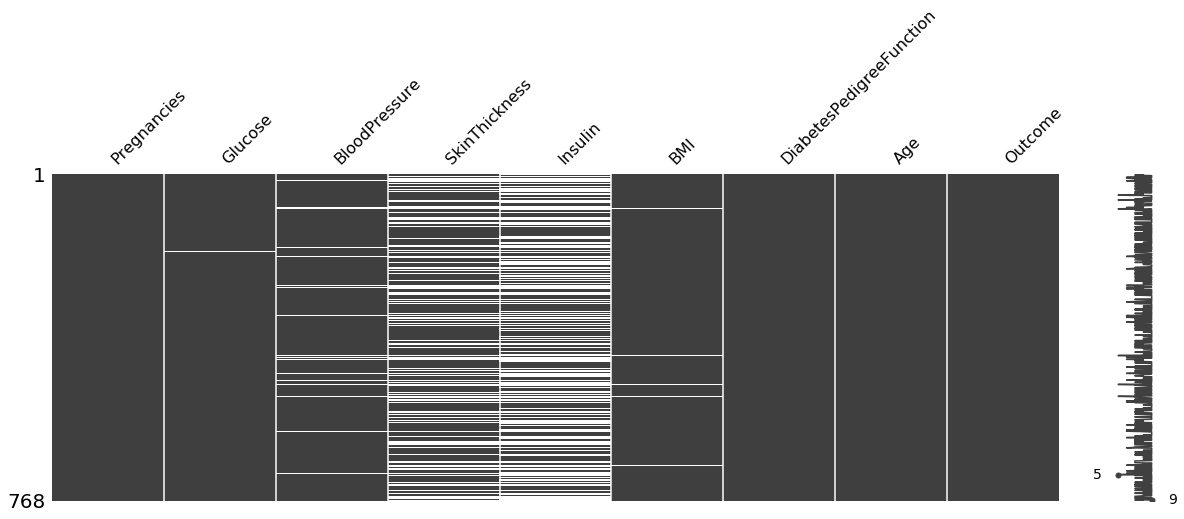

In [7]:
mno.matrix(df, figsize = (20, 6))

## Using Regression to impute missing data

When we have multiple variables with missing values, we can't just directly use Regression Imputation to impute one of them as the predictors contain missing data themselves. But then, how can we impute one variable without imputing another?

We can avoid this Catch-22 situation by initially imputing all the variables with missing values using some trivial methods like __Simple Random Imputation__ (we impute the missing data with random observed values of the variable) which is later followed by Regression Imputation of each of the variables iteratively.

In [8]:
missing_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

The function `random_imputation` replaces the missing values with some random observed values of the variable. The method is repeated for all the variables containing missing values, after which they serve as parameters in the regression model to estimate other variable values.

Simple Random Imputation is one of the crude methods since it ignores all the other available data and thus it's very rarely used. But it serves as a good starting point for regression imputation.

In [9]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [10]:
for feature in missing_columns:
    df[feature + '_imp'] = df[feature]
    df = random_imputation(df, feature)

### Deterministic Regression Imputation 

In __Deterministic Regression Imputation__, we replace the missing data with the values predicted in our regression model and repeat this process for each variable.

In [10]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = df[feature + "_imp"]
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    model = linear_model.LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])
    
    #observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[df[feature].isnull(), "Det" + feature] = model.predict(df[parameters])[df[feature].isnull()]

In [11]:
mno.matrix(deter_data, figsize = (20,5))

A major disadvantage in this method is that we reduce the inherent variability in the imputed variable. In other words, since we substitute the missing data with regression outputs, the predicted values lie along the regression hyperplane where the variable would have actually contained some noise/bias.

We can visualize the above fact in a number of ways. First one is plotting histograms for both the incomplete data and the complete data in which we can observe that the plot of the completed data is taller and narrower when compared to that of the incomplete data. In other words, the complete data has a lesser standard deviation (thus lesser variability) than the incomplete data.

Another method would be plotting a boxplot in which we can observe that the IQ Range is pretty compressed for the complete data when compared to that in the incomplete data.

In [12]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["Insulin", "SkinThickness"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'red')
    
    sns.boxplot(data = pd.concat([df[variable], deter_data["Det" + variable]], axis = 1),
                ax = axes[index, 1])
    
plt.tight_layout()

In [13]:
pd.concat([df[["Insulin", "SkinThickness"]], deter_data[["DetInsulin", "DetSkinThickness"]]], axis = 1).describe().T

### Stochastic Regression Imputation 

To add uncertainity back to the imputed variable values, we can add some normally distributed noise with a mean of zero and the variance equal to the standard error of regression estimates . This method is called as __Random Imputation__ or __Stochastic Regression Imputation__

In [14]:
random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

for feature in missing_columns:
        
    random_data["Ran" + feature] = df[feature + '_imp']
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
    
    model = linear_model.LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])
    
    #Standard Error of the regression estimates is equal to std() of the errors of each estimates
    predict = model.predict(df[parameters])
    std_error = (predict[df[feature].notnull()] - df.loc[df[feature].notnull(), feature + '_imp']).std()
    
    #observe that I preserve the index of the missing data from the original dataframe
    random_predict = np.random.normal(size = df[feature].shape[0], 
                                      loc = predict, 
                                      scale = std_error)
    random_data.loc[(df[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(df[feature].isnull()) & 
                                                                            (random_predict > 0)]


When we introduce this Gaussian noise we may end up imputing some negative values for the missing data due to the spread of the distibution for a particular pair of mean and standard deviation. But, as per our discussion earlier, there might be some variable whose values can never be zero. For example, a negative value for Insulin concentrations would be meaningless. 

We can avoid this situation by retaining the values introduced by simple random imputation which is discussed above. This apparently reduces the variability that we introduce, but it's something we have to deal with, especially in case of these variables whose values are restricted to ceratin parts of the real number line.

In [15]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["Insulin", "SkinThickness"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(random_data["Ran" + variable], kde = False, ax = axes[index, 0], color = 'red')
    axes[index, 0].set(xlabel = variable + " / " + variable + '_imp')
    
    sns.boxplot(data = pd.concat([df[variable], random_data["Ran" + variable]], axis = 1),
                ax = axes[index, 1])
    
    plt.tight_layout()

We can observe from the plots above that we have introduced some degree of variability into the variables and retained the native distribution as well.

In [16]:
pd.concat([df[["Insulin", "SkinThickness"]], random_data[["RanInsulin", "RanSkinThickness"]]], axis = 1).describe().T

An issue of concern about is that, Regression Imputation might not serve as the best method when a variable is missing majority of it's data, as in case of `insulin`. In these cases we have to use more powerful approaches as Maximum Likelihood Imputation and Multple Imputaton

### Notes

1. Regression Imputation assumes that the data is Missing At Random, more about it can be found in the refereneces below.
2. For a better Regression model, we might have to follow different Data Transformation methods depending on our data.
3. Do observe that we have included `Outcome` as one of our predictors eventhough it is caused by the other variables under scrutiny.
4. __This kernel does not describe the best method for many cases, rather it justs the demonstrates Regression Imputation as one of the methods.__

## References 

* Chapter 1, Applied Missing Data Analysis - Craig K. Enders

* [Chapter 25, Data Analysis Using Regression and
Multilevel/Hierarchical Models - Andrew Gelman, Jennifer Hill](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)

* [Missing Data](https://www.iriseekhout.com/missing-data/)

* [missingno - Missing data visualization package](https://github.com/ResidentMario/missingno)